# Model of a convenience store

This notebook shows the implementation of the simple convenience store example that we look at in class.

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

## The customer process
The customer arrives at the store, spends some time choosing items to buy, then enters the queue to pay at the cashier. 

<img src="./figures/customer_proc.png" alt="Customer process" style="width: 500px;"/>

In [2]:
def customer_proc(env, name, shoppingTime, serviceTime, customerQ, serverQ, qMonitor, waitMonitor):
    """
        Arguments
        
        env          --  the simulation environment
        name         --  a unique name for each customer
        shoppingTime --  the time spent shopping 
        serviceTime  --  the time spent paying
        customerQ    --  a list representing the queue of waiting customers in front of the cashier
        serverQ      --  a list representing cashiers waiting for customers to arrive
        qMonitor     --  a list storing observations of the queue length
        waitMonitor  --  a list storing observations of waiting times for the simulated customers 
    """
    # Enter store, check time
    timeIn = env.now
    
    # Go shopping
    yield env.timeout(shoppingTime)
    
    # Done shopping, go to the cashier
    
    # First check if the cashier is waiting passive. If so call the corresponding arrivalEvent
    if serverQ != []:
        arrivalEvent = serverQ.pop()
        arrivalEvent.succeed()
        
    serviceDoneEvent = env.event() # Create an event. This event will be triggered when the customer is finished with the service
    # The customer in line is represented by a tuple (event, serviceTime). 
    customerQ.append((serviceDoneEvent, serviceTime )) 
    
    qMonitor.append((env.now, len(customerQ))) # Record the queue length
    
    yield serviceDoneEvent # Don't know how long to wait, the event will be called by the cashier 
    
    # Done paying. Check time and leave
    waitMonitor.append(env.now-timeIn)
    

## The cashier process
The cashier takes care of the customers, one at the time, in the order they arrived to the queue. When no customers are waiting in line, the cashier will passivate, waiting for the event of a new customer arriving.

<img src="./figures/cashier_proc.png" alt="Cashier process" style="width: 500px;"/>

In [3]:
def cashier_proc(env, customerQ, serverQ, qMonitor):
    """
        Arguments
        
        env          --  the simulation environment
        customerQ    --  a list representing the queue of waiting customers in front of the cashier
        serverQ      --  a list representing cashiers waiting for customers to arrive
        qMonitor     --  a list storing observations of the queue length
    """
    # Working 24/7
    while True:
        # Check if customer waiting in line
        while customerQ != []:
            (doneEvent, serveTime) = customerQ.pop(0) # Remove first customer from queue
            qMonitor.append((env.now, len(customerQ))) # Record length of queue
            
            yield env.timeout(serveTime) # Wait for the timeout event to happen. Then the service is finished
            doneEvent.succeed() # Trigger the event to inform the waiting customer that the service is done
        # No more customers waiting.
        arrivalEvent = env.event() # Create a new event indicating a new arrival
        serverQ.append(arrivalEvent) # The next customer will find this event and call it
        yield arrivalEvent # Wait until the arrival event happens
        
        

## The customer generator process
This process is quite standard. The process waits for a random time, then generates and activates a new customer.

<img src="./figures/customergen_proc.png" alt="Customer generator process" style="width: 300px;"/>

In [11]:
def customer_generator_proc(env, customerQ, serverQ, 
                            qMonitor, waitMonitor):
    """
        Arguments

        env            --  the simulation environment
        customerQ                     --  a list representing the queue of waiting customers
        serverQ                       --  a list representing cashiers waiting for customers to arrive
        qMonitor                      --  a list storing observations of the queue length
        waitMonitor                   --  a list storing observations of waiting times
    """
    k = 0
    while True:
        # On average two customers per minute enters
        yield env.timeout( random.expovariate( 2 ) ) 
        # Wait done. Start new customer process
        k += 1
        env.process(customer_proc(env, "C-%d" % k, 
                                  random.uniform(0.2, 3),
                                  random.gammavariate(3, 0.2/3),
                                  customerQ, serverQ, 
                                  qMonitor, waitMonitor))
    

In [ ]:
dir(random)

## The main program
Now that all the processes are defined, we can run the simulation. For convenience, we define a function that runs the simulation once. This makes it easy to do repeated simulations of the model.

Here, we simulate the particular case that is also simulated by hand in class.

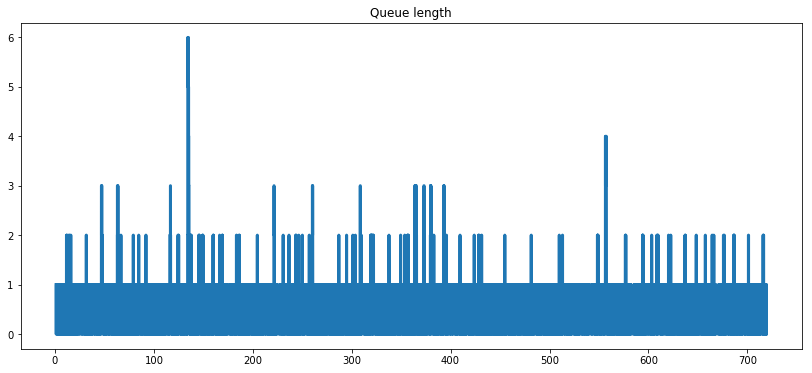

In [12]:
def run_sim_once():
    
    customerQ = []   # A list to hold the waiting customers
    serverQ = []     # A list to hold servers waiting for customers
    qMonitor = []    # A list to hold recorded queue lengths througout the simulation
    waitMonitor = [] # A list to hold recorded wait times 
    
    env = simpy.Environment()
    
    # Start cashier process
    env.process(cashier_proc(env, customerQ, serverQ, qMonitor))
    
    # Start the customer generator process
    env.process( customer_generator_proc(env, customerQ, serverQ, 
                                        qMonitor, waitMonitor) )
    
    # Simulate
    env.run(until = 12*60)

    #print( qMonitor )
    qlen = np.asarray(qMonitor) # Turn into numpy array
    plt.figure(figsize=(14,6))
    plt.step(qlen[:,0], qlen[:,1], where='post', linewidth=3 )
    plt.title("Queue length")
    plt.show()
    
run_sim_once()